## Load the model

In [1]:
import os
import gensim.models as g
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import json
import matplotlib.pyplot as plt # vizualizare dendograma
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
model="../../oldDBLP/enwiki_dbow/doc2vec.bin"

#inference hyper-parameters
start_alpha=0.01
infer_epoch=1000

#load model
m = g.Doc2Vec.load(model)

In [33]:
def apply_doc2vec(fileIn):
    r = open(fileIn,'r',encoding='utf-8')
    X = []
    
    doc_list = json.load(r)
    i = 0
    for elem in doc_list:
        if i % 1000 == 0:
            print (i)
        i += 1
        inferred_vector = m.infer_vector(elem, alpha=start_alpha, steps=infer_epoch)
        X.append(inferred_vector)
    r.close()
    return X

X = np.array(apply_doc2vec('../preprocesareFOS/fos_list_reduced_3_1000.txt'))
np.save('X_FOS_3_1000.npy', X) 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000


In [36]:
print(len(X),X.shape)

57803 (57803, 300)


In [2]:
X = np.load('X_FOS_3_1000.npy')
print(X.shape)

(57803, 300)


## Elbow method

10
20
30
40


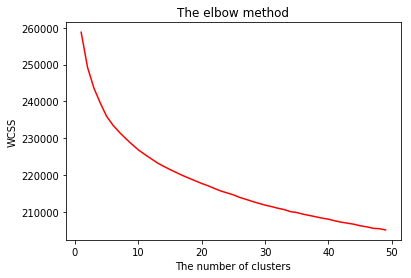

In [38]:
def elbow_kmeans(X):
    wcss = []
    for i in range(1,50):
        if i % 10 == 0:
            print (i)
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 10, random_state = 0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_) 
    return wcss

wcss = elbow_kmeans(X)
plt.plot(range(1,50), wcss, 'r')
plt.title('The elbow method')
plt.xlabel('The number of clusters')
plt.ylabel('WCSS')
plt.show()

#https://medium.com/@iSunilSV/data-science-python-k-means-clustering-eed68b490e02

## K-Means and Silhouette

For n_clusters = 55 The average silhouette_score is : 0.019522863
For n_clusters = 56 The average silhouette_score is : 0.017674152
For n_clusters = 57 The average silhouette_score is : 0.019567525
For n_clusters = 58 The average silhouette_score is : 0.017750105
For n_clusters = 59 The average silhouette_score is : 0.018332059


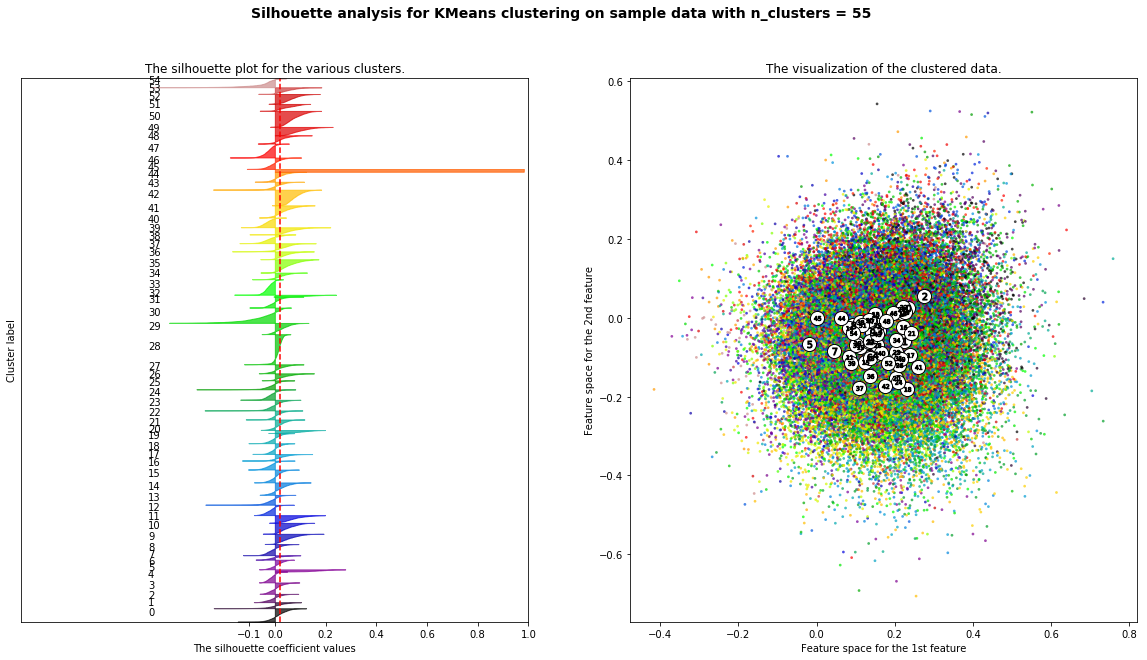

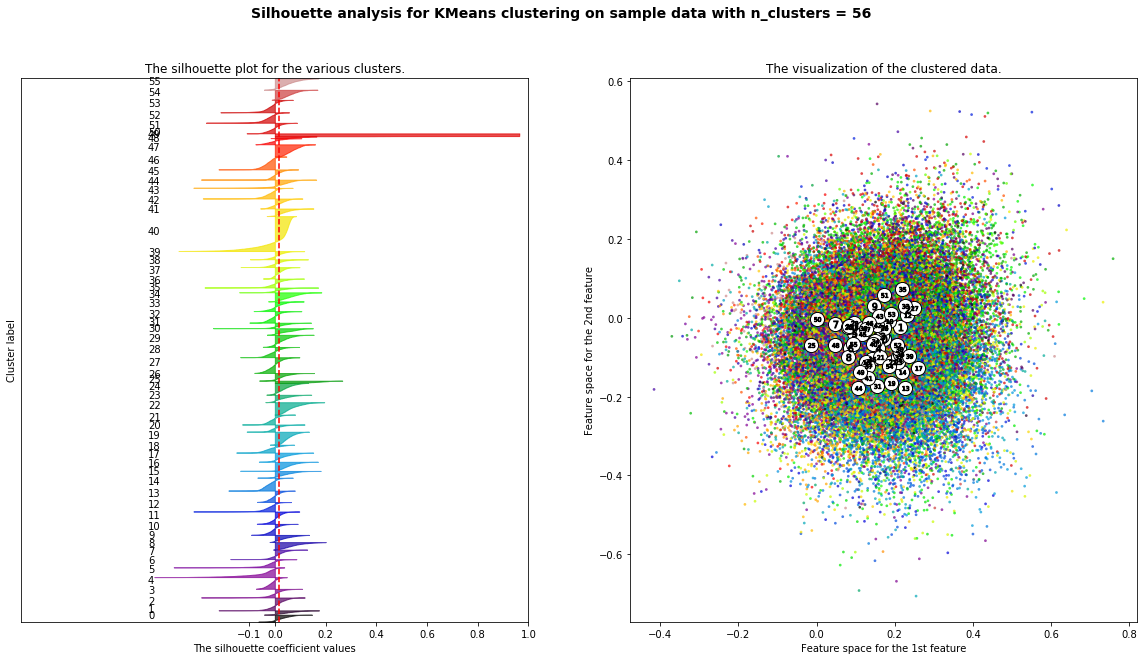

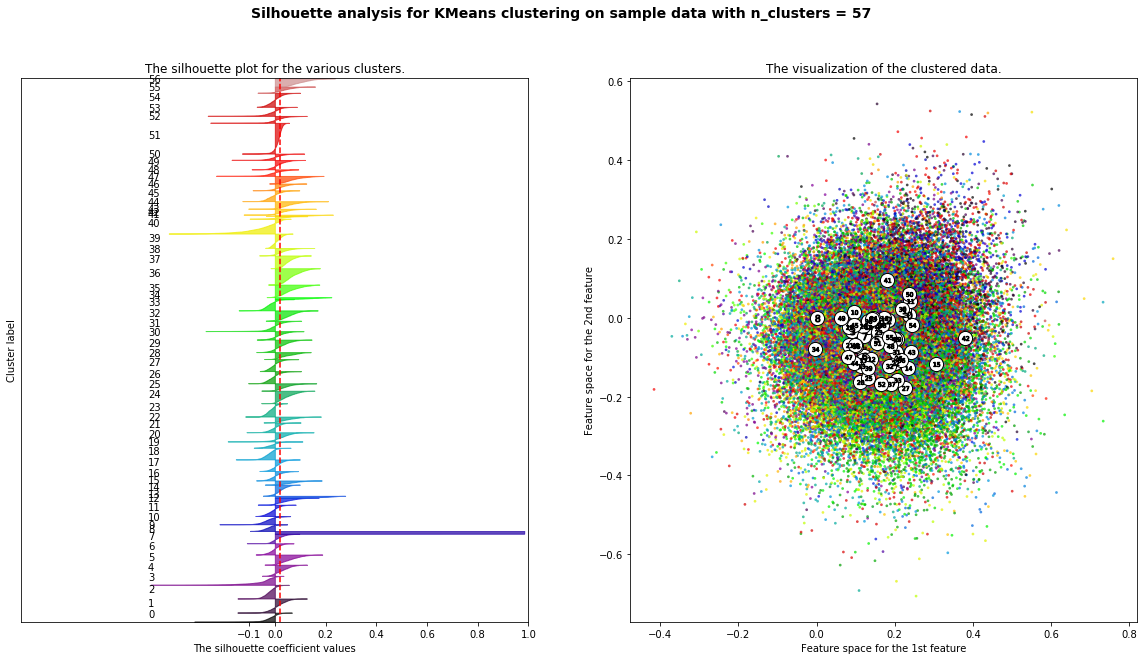

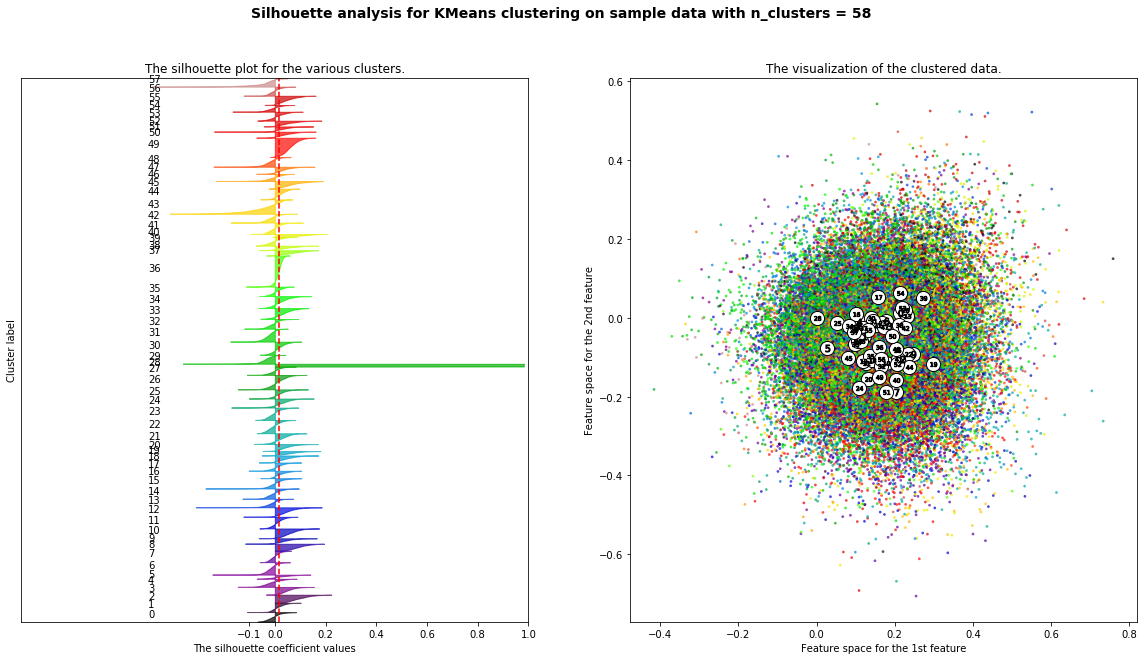

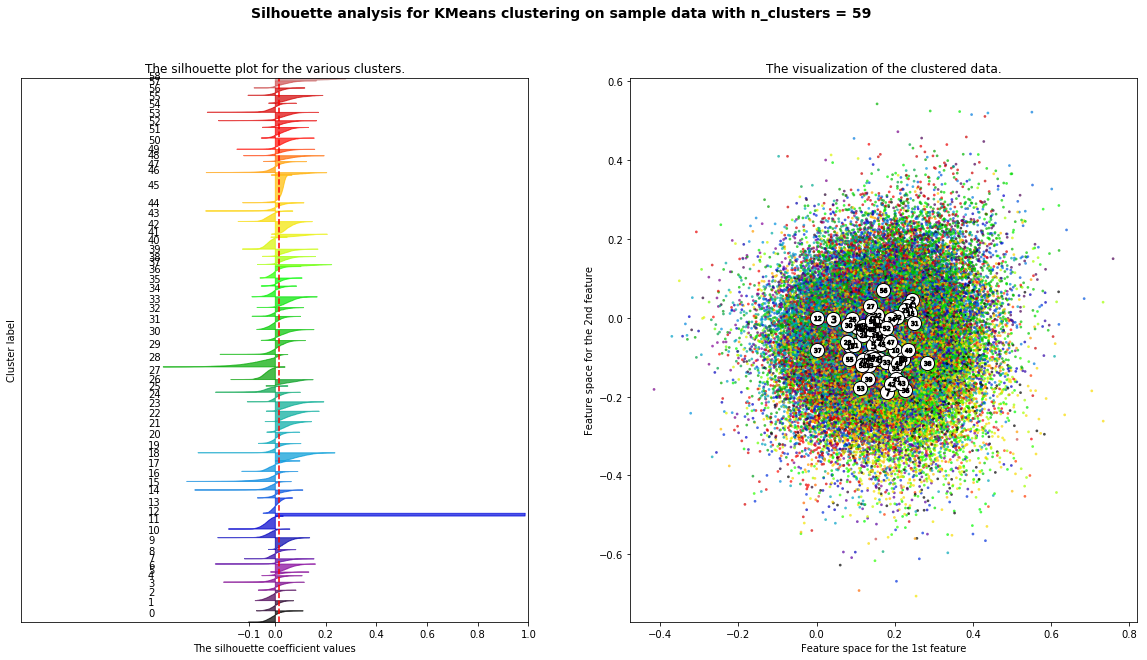

In [3]:
for n_clusters in range(55,60):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.5, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.savefig('SilhouetteAnalysis15.png')

## DUNN Index

In [40]:
def delta_fast(ck, cl, distances):
    values = distances[np.where(ck)][:, np.where(cl)]
    values = values[np.nonzero(values)]

    return np.min(values)
    
def big_delta_fast(ci, distances):
    values = distances[np.where(ci)][:, np.where(ci)]
    #values = values[np.nonzero(values)]
            
    return np.max(values)
    
def dunn(points, labels):
    """  points : np.array   np.array([N, p]) of all points
    labels: np.array   np.array([N]) labels of all points
    """
    distances = euclidean_distances(points)
    ks = np.sort(np.unique(labels))
    
    deltas = np.ones([len(ks), len(ks)])*1000000
    big_deltas = np.zeros([len(ks), 1])
    
    l_range = list(range(0, len(ks)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta_fast((labels == ks[k]), (labels == ks[l]), distances)
        
        big_deltas[k] = big_delta_fast((labels == ks[k]), distances)

    di = np.min(deltas)/np.max(big_deltas)
    return di

In [41]:
df = pd.DataFrame(X) 
  
for i in range(15,30):
    k_means = KMeans(n_clusters=i, random_state=0) 
    k_means.fit(df) #K-means training 
    print(i, dunn(X, k_means.labels_))
    

MemoryError: 